In [1]:
from shapely.geometry import Polygon
from pyproj import Geod
import math
import scipy
import chaosmagpy as cp
from matplotlib.path import Path
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def dx(ym, xm, f):
    dxm = np.abs(xm[0, 1] - xm[0, 0])
    der = (np.roll(f, -1, axis=1) - np.roll(f, 1, axis=1)) / (2 * dxm)
    der[:, 0] = (f[:, 1] - f[:, -2]) / (2 * dxm)
    der[:, -1] = der[:, 0]
    return der

def dy(ym, xm, f):
    dym = np.abs(ym[1, 0] - ym[0, 0])
    der = (np.roll(f, -1, axis=0) - np.roll(f, 1, axis=0)) / (2 * dym)
    der[0, :] = (f[1, :] - f[0, :]) / dym
    der[1, :] = (f[-1, :] - f[-2, :]) / dym
    return der

def ddy(ym, xm, f):
    dym = np.abs(ym[1, 0] - ym[0, 0])
    der = (np.roll(f, 1, axis=0) - 2 * f + np.roll(f, -1, axis=0)) / (dym ** 2)
    der[0, :] = der[1, :]
    der[-1, :] = der[-2, :]
    return der

def ddx(ym, xm, f):
    dxm = np.abs(xm[0, 1] - xm[0, 0])
    der = (np.roll(f, 1, axis=1) - 2 * f + np.roll(f, -1, axis=1)) / (dxm ** 2)
    der[:, 0] = (f[:, 1] - 2 * f[:, 0] + f[:, -2]) / (dxm ** 2)
    der[:, -1] = der[:, 0]
    return der


def detH(ddx, ddy):
    derH = (ddx * ddy)
    return derH

def read_gauss_coeffs(filename, target_year, lmax=25):
    """
    已经经过修正的20250703
    Histkalmag格式的文件中读取指定年份的高斯系数，
    输出 gsh 和 hsh 按 (l, m) 顺序排列。
    """
    with open(filename, 'r') as f:
        lines = f.readlines()

    years = list(map(float, lines[0].strip().split()))
    if target_year not in years:
        raise ValueError(f"目标年份 {target_year} 不在数据中")
    idx = years.index(target_year)

    coeff_lines = lines[1:len(lines)]
    coeffs = [list(map(float, line.strip().split())) for line in coeff_lines]

    coeffs_at_year = [row[idx] for row in coeffs]
    gsh = []
    hsh = []
    i = 0
    for l in range(1, lmax + 1):
        for m in range(0, l + 1):
            if m == 0:
                gsh.append(coeffs_at_year[i])
                i += 1
                hsh.append(0.0)
            else:
                gsh.append(coeffs_at_year[i])
                i += 1
                hsh.append(coeffs_at_year[i])
                i += 1
    return np.array(gsh), np.array(hsh)


# 计算主磁场
def magnetic_field(gsh, hsh, lmax, r, lats, lons):
    a = 6371.2
    pi = math.pi
    # lats          =  np.linspace(1., 179., num=181)
    # lons          =  np.linspace(-180., 180., num=181)
    lons2d, lats2d = np.meshgrid(lons, lats)
    phi = lons2d
    cost2d = np.cos((lats2d) * np.pi / 180)
    i = 0
    br = np.zeros(cost2d.shape)
    bphi = np.zeros(cost2d.shape)
    btheta = np.zeros(cost2d.shape)
    for l in np.arange(1, lmax + 1, 1):
        for m in np.arange(0, l + 1, 1):
            g = gsh[i]
            h = hsh[i]
            # calculate schmidt
            if m == 0:
                schmidt = 1.0
            else:
                schmidt = ((-1.0) ** m) * np.sqrt(2.0 * math.factorial(l - m) / math.factorial(l + m))
            lagendre = scipy.special.lpmv(m, l, cost2d)
            lagendre_ = scipy.special.lpmv(m, l - 1, cost2d)
            div_lagendre = (l * cost2d * lagendre - (l + m) * lagendre_) / np.sqrt(1 - cost2d ** 2)
            br = br + schmidt * (float(l) + 1.0) * ((a / r) ** (l + 2)) * lagendre * (
                        g * np.cos(float(m) * phi * pi / 180.0)
                        + h * np.sin(float(m) * phi * pi / 180.0))
            bphi = bphi + schmidt * (m / np.sin((lats2d) * pi / 180)) * ((a / r) ** (l + 2)) * lagendre * (
                        -g * np.sin(float(m) * phi * pi / 180.0)
                        + h * np.cos(float(m) * phi * pi / 180.0))
            btheta = btheta + schmidt * ((a / r) ** (l + 2)) * (div_lagendre) * (
                        g * np.cos(float(m) * phi * pi / 180.0) + h * np.sin(float(m) * phi * pi / 180.0))
            i += 1
    return br, bphi, btheta, lons2d, lats2d


def mean_F(f, thetam):
    theta_rad = np.deg2rad(thetam)
    sin = np.sin(theta_rad)
    product_sum = np.sum(f[30:151, :] * sin[30:151, :])
    C = np.sum(sin[30:151, :])
    mean = product_sum / C
    return mean


def calculate_integral(B):
    # 计算归一化 积分
    phi_range = np.linspace(0, 2 * np.pi, B.shape[1] + 1)  # 经度范围
    theta_range = np.linspace(0, np.pi, B.shape[0] + 1)  # 纬度范围

    integrals = [0, 0]
    theta_min = np.deg2rad(25)
    theta_max = np.deg2rad(155)
    region_boundaries = [
        [(0, 2 * np.pi), (0, theta_min)],
        [(0, 2 * np.pi), (theta_max, np.pi)]]
    for i, region in enumerate(region_boundaries):
        for j in range(len(phi_range) - 1):
            for k in range(len(theta_range) - 1):
                phi_lower = phi_range[j]
                phi_upper = phi_range[j + 1]
                theta_lower = theta_range[k]
                theta_upper = theta_range[k + 1]
                sin_theta = np.sin((theta_lower + theta_upper) / 2)
                d_phi = phi_upper - phi_lower
                d_theta = theta_upper - theta_lower

                if region[0][0] <= (phi_lower + phi_upper) / 2 <= region[0][1] and region[1][0] <= (
                        theta_lower + theta_upper) / 2 <= region[1][1]:
                    integrals[i] += B[k, j] * sin_theta * d_phi * d_theta
    integral = sum(integrals)
    return integral


# 计算Fout
def F_boundary(constant, B, B_t0):
    Fup = calculate_integral(B)
    Fdown = calculate_integral(B_t0)
    F_out = Fup / Fdown
    # F边界
    boundaryF = constant * F_out
    return boundaryF

In [3]:
def pointF_Chaos(time,colatlist,lonlist):
    model = cp.load_CHAOS_matfile('D:\Fig\origin data\coeff\CHAOS-8.2.mat')
    radius=6371
    if np.isscalar(colatlist):
        # 单点，grid=False
        Bx, By, Bz = model.synth_values_tdep(time, radius, colatlist, lonlist, grid=False)
    else:
        # 多点，默认grid=True
        Bx, By, Bz = model.synth_values_tdep(time, radius, colatlist, lonlist)

    F = np.sqrt(Bx ** 2 + By ** 2 + Bz ** 2) / 1000
    return F

In [4]:
def F_C_ObO(x, y, fun1,fun2,lev):
    c_fx = plt.contour(x, y, fun1, levels=[lev])
    c_fy = plt.contour(x, y, fun2, levels=[lev])

    Line_dx=[]
    points_dx=[]
    paths = c_fx.get_paths()
    polygons = paths[0].to_polygons()
    for i, poly in enumerate(polygons):
        verts = poly
        if abs(verts[-1,0]-verts[-2,0])>10 or abs(verts[-1,1]-verts[-2,1])>10:
            zz=2
        else:
            zz=1
        points_dx.extend(verts)
        FxLine=[]
        for v in range(len(verts) - zz):
            xa,ya=verts[v]
            xb,yb=verts[v+1]
            xlist= np.array([xa,xb])
            ylist= np.array([ya,yb])
            # 如果两个点太近（避免 polyfit 崩溃）
            if np.isclose(xa, xb) and np.isclose(ya, yb):
                continue  # 跳过这对点
            try:
                k, b = np.polyfit([xa, xb], [ya, yb], deg=1)
            except np.linalg.LinAlgError:
                print(f"警告：polyfit 在点 ({xa}, {ya}) - ({xb}, {yb}) 拟合失败，已跳过。")
                continue
    
            k, b = np.polyfit(xlist, ylist, deg=1)
            FxLine.append([k, b, xa, xb, ya, yb])
    
        Line_dx.append(np.array(FxLine))
    
    Line_dy = []
    points_dy=[]
    paths = c_fy.get_paths()
    polygons = paths[0].to_polygons()
    for i, poly in enumerate(polygons):
        verts = poly

        if abs(verts[-1,0]-verts[-2,0])>10 or abs(verts[-1,1]-verts[-2,1])>10:
            zz=2
        else:
            zz=1
        points_dy.extend(verts)
        FyLine=[]
        for v in range(len(verts) - zz):
            xa,ya=verts[v]
            xb,yb=verts[v+1]
            xlist= np.array([xa,xb])
            ylist= np.array([ya,yb])
            # 如果两个点太近（避免 polyfit 崩溃）
            if np.isclose(xa, xb) and np.isclose(ya, yb):
                continue  # 跳过这对点
            try:
                k, b = np.polyfit([xa, xb], [ya, yb], deg=1)
            except np.linalg.LinAlgError:
                print(f"警告：polyfit 在点 ({xa}, {ya}) - ({xb}, {yb}) 拟合失败，已跳过。")
                continue
    
            k, b = np.polyfit(xlist, ylist, deg=1)
            FyLine.append([k, b, xa, xb, ya, yb])
        Line_dy.append(np.array(FyLine))
    
    x_cross=[]
    y_cross=[]
    for n in range(0, len(Line_dx)):
        Fx = Line_dx[n]
        for m in range(0, len(Line_dy)):
            Fy = Line_dy[m]
            for p in range(0, len(Fx[:,0])):
                k1,b1,x1,x2,y1,y2=Fx[p, :]
                for q in range(0, len(Fy[:,0])):
                    k2,b2,x3,x4,y3,y4=Fy[q, :]
                    x_c= (b2 - b1) / (k1 - k2)
                    if x_c is not None:
                        # 判断x_c是否在两段线段的x范围内
                        in_range_1 = (min(x1, x2) <= x_c <= max(x1, x2))
                        in_range_2 = (min(x3, x4) <= x_c <= max(x3, x4))
                        if in_range_1 and in_range_2:
                            y_c = k1 * x_c + b1
                            if y_c is not None:
                                # 判断x_c是否在两段线段的x范围内
                                in_range_3 = (min(y1, y2) <= y_c <= max(y1, y2))
                                in_range_4 = (min(y3, y4) <= y_c <= max(y3, y4))
                                if in_range_3 and in_range_4:
                                    x_cross.append(x_c)
                                    y_cross.append(y_c)
    
    x_cross = np.array(x_cross)
    y_cross = np.array(y_cross)
    
    # 创建布尔掩码，筛选 x 在 [5, 175] 范围内的点
    mask = (y_cross >= 5) & (y_cross <= 175)
    x_cross = x_cross[mask]
    y_cross = y_cross[mask]
    return x_cross,y_cross


def detH_saddle(DETH, thetam, phim, crossingsX,crossingsY):

    lat_grid = thetam[:, 0]
    lon_grid = phim[0, :]

    interp_func = scipy.interpolate.RegularGridInterpolator((lat_grid, lon_grid), DETH,
                                                            bounds_error=False,
                                                            fill_value=np.nan)
    cross = np.column_stack((crossingsX, crossingsY))
    cross = np.array(cross)
    points_for_interp = cross[:, [1, 0]]
    # 插值
    values = interp_func(points_for_interp)


    # 分类
    pos_mask = values > 0
    neg_mask = values <= 0

    pos_points = points_for_interp[pos_mask]
    neg_points = points_for_interp[neg_mask]

    return pos_points, neg_points

In [5]:

# 计算主磁场
def magnetic_point(gsh, hsh, lmax, r, lats, lons):
    a = 6371.2
    pi = math.pi
    # lats          =  np.linspace(1., 179., num=181)
    # lons          =  np.linspace(-180., 180., num=181)
    lons2d, lats2d = lons, lats
    phi = lons2d
    cost2d = np.cos((lats2d) * np.pi / 180)
    i = 0
    br = np.zeros(cost2d.shape)
    bphi = np.zeros(cost2d.shape)
    btheta = np.zeros(cost2d.shape)
    for l in np.arange(1, lmax + 1, 1):
        for m in np.arange(0, l + 1, 1):
            g = gsh[i]
            h = hsh[i]
            # calculate schmidt
            if m == 0:
                schmidt = 1.0
            else:
                schmidt = ((-1.0) ** m) * np.sqrt(2.0 * math.factorial(l - m) / math.factorial(l + m))
            lagendre = scipy.special.lpmv(m, l, cost2d)
            lagendre_ = scipy.special.lpmv(m, l - 1, cost2d)
            div_lagendre = (l * cost2d * lagendre - (l + m) * lagendre_) / np.sqrt(1 - cost2d ** 2)
            br = br + schmidt * (float(l) + 1.0) * ((a / r) ** (l + 2)) * lagendre * (
                        g * np.cos(float(m) * phi * pi / 180.0)
                        + h * np.sin(float(m) * phi * pi / 180.0))
            bphi = bphi + schmidt * (m / np.sin((lats2d) * pi / 180)) * ((a / r) ** (l + 2)) * lagendre * (
                        -g * np.sin(float(m) * phi * pi / 180.0)
                        + h * np.cos(float(m) * phi * pi / 180.0))
            btheta = btheta + schmidt * ((a / r) ** (l + 2)) * (div_lagendre) * (
                        g * np.cos(float(m) * phi * pi / 180.0) + h * np.sin(float(m) * phi * pi / 180.0))
            i += 1
    return br, bphi, btheta, lons2d, lats2d

from matplotlib.ticker import ScalarFormatter

In [6]:
def magnetic_point(gsh, hsh, lmax, r, y, x):
    fi=[]
    for i in range(0,len(y)):
        br,bphi,btheta,_,_=magnetic_field(gsh, hsh, lmax, radius, y[i], x[i])
        fff=np.sqrt(br**2 + bphi**2 + btheta**2)/1000
        fi.append(fff)
    return np.array(fi).squeeze()


In [7]:
def num_conter(in_F,in_level):#计算独立面积数量
    c_fs = plt.contour(phi, theta, in_F, levels=in_level)   # get contour
    paths2 = c_fs.get_paths()          # get contour path(all)
    polygons2 = paths2[0].to_polygons()
    
    nn=0
    zz=0
    for poly in polygons2:
        lat_line=poly[:,1]
        lon_line=poly[:,0]
        
        if (np.isclose(poly[0,0], 360.0) and np.isclose(poly[-1,0], 360.0)) \
                   or (np.isclose(poly[0,0], 0.0) and np.isclose(poly[-1,0], 0.0)):
            zz=1+zz
        else:
            nn=nn+1
        plt.plot(poly[:,0], poly[:,1])
    
    Num=nn+(zz/2)
    return(Num)

def AREA(lats_fo,lons_fo): #边界经纬度  #输入的lat_fo需要已经经过了90-lat
    # lats_fo = 90 - poly[:, 1]
    # lons_fo = poly[:, 0]
    geod = Geod(ellps="WGS84")
    polygon = Polygon(zip(lons_fo, lats_fo))
    area_fo, _ = geod.geometry_area_perimeter(polygon)
    area_km2_fo = abs(area_fo) / 1e6
    return area_km2_fo
    
def all_area(polygons2):
    total_area_add = 0.0   # 存放需要加合的等值线的总面积
    areas_not_add = []
    nn=0
    zz=0
    for poly in polygons2:
        lat_line=90-poly[:,1]
        lon_line=poly[:,0]
        
        if (np.isclose(poly[0,0], 360.0) and np.isclose(poly[-1,0], 360.0)) \
                   or (np.isclose(poly[0,0], 0.0) and np.isclose(poly[-1,0], 0.0)):
            zz=1+zz
            area_need_add=AREA(lat_line,lon_line) # 面积
            total_area_add += area_need_add #加和面积
        else:
            nn=nn+1
            area_not_add=AREA(lat_line,lon_line) # 面积
            areas_not_add.append(area_not_add)
    
    
        plt.plot(poly[:,0], poly[:,1])
    
    if zz>1:
        areas_not_add.append(total_area_add) #最后的所有的面积
    
    print(areas_not_add)
    Num=nn+(zz/2)
    
    print('合并后条数',Num)
    return np.array(areas_not_add)
    #输出 等值线条数

def collect_inside(lats_fo, lons_fo,thetam,phim):  # 收集每个区域的信息。最后需要自己合并一下再计算
        # 准备网格点坐标
    lat_grid = 90 - thetam    # 纬度 φ
    lon_grid = phim           # 经度 φ
    theta_grid = thetam
    
    polygon_path = Path(np.vstack([lons_fo, lats_fo]).T)
    grid_points = np.vstack([lon_grid.ravel(), lat_grid.ravel()]).T
    inside = polygon_path.contains_points(grid_points)
    if not np.any(inside):
        return np.array([]), np.array([]), np.array([])
    # 提取区域内的经度、余纬和磁强度
    phi_in = grid_points[inside, 0]       # 经度
    theta_in = theta_grid.ravel()[inside] # 余纬
    F_in = F.ravel()[inside]              # 磁场强度

    return phi_in, theta_in, F_in

def CenterOfMass(All_phi_inside,All_theta_inside,All_F_inside):
    # 加权计算质心
    w_sum = (1/All_F_inside)
    w_sin = np.sin(All_theta_inside*np.pi/180)
    phi_cm_Fc = np.sum(All_phi_inside * w_sum * w_sin) / np.sum(w_sum * w_sin)
    phi_cm_Fc = phi_cm_Fc % 360
    theta_cm_Fc = np.sum(All_theta_inside * w_sin  *  w_sum ) /  np.sum(w_sum * w_sin)           # 保留余纬
    # print("Fc 的 center of mass：","lat=",theta_cm_Fc,"lon=",phi_cm_Fc)
    return theta_cm_Fc, phi_cm_Fc

def all_center(polygons2):
    inside_add_phi = []
    inside_add_theta = []
    inside_add_F = []
    theta_output=[]
    phi_output=[]
    nn=0
    zz=0
    for poly in polygons2:
        lat_line=90-poly[:,1]
        lon_line=poly[:,0]
        
        if (np.isclose(poly[0,0], 360.0) and np.isclose(poly[-1,0], 360.0)) \
                   or (np.isclose(poly[0,0], 0.0) and np.isclose(poly[-1,0], 0.0)):
            zz=1+zz
            
            phi_in,theta_in,F_in=collect_inside(lat_line,lon_line,thetam,phim)
            inside_add_phi.append(phi_in) 
            inside_add_theta.append(theta_in) 
            inside_add_F.append(F_in) 
            
        else:
            nn=nn+1
            
            phi_in,theta_in,F_in=collect_inside(lat_line,lon_line,thetam,phim)
            theta_CM, phi_CM=CenterOfMass(phi_in,theta_in,F_in)
            theta_output.append(theta_CM)
            phi_output.append(phi_CM)
    
        plt.plot(poly[:,0], poly[:,1])
    
    if zz>1:
        inside_add_phi = np.concatenate(inside_add_phi)
        inside_add_theta = np.concatenate(inside_add_theta)
        inside_add_F = np.concatenate(inside_add_F)
        inside_add_phi = ((inside_add_phi + 180) % 360) - 180
        
        theta_CM, phi_CM=CenterOfMass(np.array(inside_add_phi),np.array(inside_add_theta),np.array(inside_add_F)) #最后的所有的面积
        theta_output.append(theta_CM)
        phi_output.append(phi_CM)
    
    print(theta_output,phi_output)
    Num=nn+(zz/2)
    print('合并后条数',Num)
    return phi_output,theta_output   #输出 每个区域的面积的 center of mass

def selecte(F_S,Fc):
    mask_S = F_S < Fc
    F_S_selected = F_S[mask_S]
    return F_S_selected

In [8]:
#改动 center of math 计算
from matplotlib.ticker import ScalarFormatter
import chaosmagpy as cp
import matplotlib.colors as mcolors

cmap="RdGy"# 'PuOr_r'
linecolor="forestgreen"
vmin = 20
vmax = 70

fontweight='bold'
fontname='Arial'
fontsize=14
markersize = 70
SaddleColor="k"
SaddleMarker="o"
ExtremaColor="white"
ExtremaMarker="^"

massmarker_Fs="+"
massmarker="x"
masscolor="forestgreen"
masssize=60


In [9]:
radius = 6371.
theta = np.linspace(1., 179., num=181)  # colatitude in degrees
phi = np.linspace(0., 360., num=361)  # longitude in degrees 改区间需要修改
phim, thetam = np.meshgrid(phi, theta)
radiusm = radius * np.ones(phim.shape)
filepath="D:\Fig\origin data\coeff\covobsx2.txt"

lmax=14
r=6371
n=1

gsh, hsh = read_gauss_coeffs(filepath, 2020, lmax=lmax)
br,bphi,btheta,lons2d,lats2d=magnetic_field(gsh, hsh, lmax, radius, theta, phi)
F2020=np.sqrt(br**2 + bphi**2 + btheta**2)/1000
Fo2020=calculate_integral(F2020)

区域内的E和S点数量分别为： 1 0
sub-region 数量为 1.0
[60633070.54144394]
合并后条数 1.0
[np.float64(104.24761106494454)] [np.float64(346.77733504982604)]
合并后条数 1.0
最终划分的面积数 1
[1.]
[np.float64(104.24761106494454)] [np.float64(346.77733504982604)]
合并后条数 1.0
[60633070.54144394]
合并后条数 1.0
区域内的E和S点数量分别为： 1 0
sub-region 数量为 1.0
[60661695.00849706]
合并后条数 1.0
[np.float64(104.20542059035722)] [np.float64(346.0942717674182)]
合并后条数 1.0
最终划分的面积数 1
[1.]
[np.float64(104.20542059035722)] [np.float64(346.0942717674182)]
合并后条数 1.0
[60661695.00849706]
合并后条数 1.0
区域内的E和S点数量分别为： 1 0
sub-region 数量为 1.0
[60838182.620652914]
合并后条数 1.0
[np.float64(104.15968361890259)] [np.float64(345.3484081073419)]
合并后条数 1.0
最终划分的面积数 1
[1.]
[np.float64(104.15968361890259)] [np.float64(345.3484081073419)]
合并后条数 1.0
[60838182.620652914]
合并后条数 1.0
区域内的E和S点数量分别为： 1 0
sub-region 数量为 1.0
[61237989.02570157]
合并后条数 1.0
[np.float64(104.13314332915245)] [np.float64(344.72245257002294)]
合并后条数 1.0
最终划分的面积数 1
[1.]
[np.float64(104.13314332915245)] [np.float64

D:\Anaconda\envs\Saddle\Lib\site-packages\numpy\lib\_polynomial_impl.py:674: RuntimeWarning: invalid value encountered in divide
  lhs /= scale


警告：polyfit 在点 (0.0, 167.6906916777832) - (0.0, 175.68658154378772) 拟合失败，已跳过。
区域内的E和S点数量分别为： 1 0
sub-region 数量为 1.0
[75770967.4948884]
合并后条数 1.0
[np.float64(106.57770331263501)] [np.float64(321.92862400754615)]
合并后条数 1.0
最终划分的面积数 1
[1.]
[np.float64(106.57770331263501)] [np.float64(321.92862400754615)]
合并后条数 1.0
[75770967.4948884]
合并后条数 1.0
区域内的E和S点数量分别为： 1 0
sub-region 数量为 1.0
[75865111.64705694]
合并后条数 1.0
[np.float64(106.83790528589977)] [np.float64(321.75386303745876)]
合并后条数 1.0
最终划分的面积数 1
[1.]
[np.float64(106.83790528589977)] [np.float64(321.75386303745876)]
合并后条数 1.0
[75865111.64705694]
合并后条数 1.0
区域内的E和S点数量分别为： 1 0
sub-region 数量为 1.0
[76067834.87690543]
合并后条数 1.0
[np.float64(107.11192118449168)] [np.float64(321.4252127642622)]
合并后条数 1.0
最终划分的面积数 1
[1.]
[np.float64(107.11192118449168)] [np.float64(321.4252127642622)]
合并后条数 1.0
[76067834.87690543]
合并后条数 1.0
区域内的E和S点数量分别为： 1 0
sub-region 数量为 1.0
[76620605.82811844]
合并后条数 1.0
[np.float64(107.40007590776253)] [np.float64(321.374457334369

C:\Users\yue-y\AppData\Local\Temp\ipykernel_13460\1225394214.py:58: RankWarning: Polyfit may be poorly conditioned
  k, b = np.polyfit([xa, xb], [ya, yb], deg=1)
C:\Users\yue-y\AppData\Local\Temp\ipykernel_13460\1225394214.py:63: RankWarning: Polyfit may be poorly conditioned
  k, b = np.polyfit(xlist, ylist, deg=1)


区域内的E和S点数量分别为： 1 0
sub-region 数量为 1.0
[81527497.28926313]
合并后条数 1.0
[np.float64(108.63472596469606)] [np.float64(322.44416944135764)]
合并后条数 1.0
最终划分的面积数 1
[1.]
[np.float64(108.63472596469606)] [np.float64(322.44416944135764)]
合并后条数 1.0
[81527497.28926313]
合并后条数 1.0
区域内的E和S点数量分别为： 1 0
sub-region 数量为 1.0
[82477537.51228397]
合并后条数 1.0
[np.float64(108.88191736885875)] [np.float64(322.5380951109497)]
合并后条数 1.0
最终划分的面积数 1
[1.]
[np.float64(108.88191736885875)] [np.float64(322.5380951109497)]
合并后条数 1.0
[82477537.51228397]
合并后条数 1.0
区域内的E和S点数量分别为： 1 0
sub-region 数量为 1.0
[83423669.64954604]
合并后条数 1.0
[np.float64(109.05870992801442)] [np.float64(322.6383520541185)]
合并后条数 1.0
最终划分的面积数 1
[1.]
[np.float64(109.05870992801442)] [np.float64(322.6383520541185)]
合并后条数 1.0
[83423669.64954604]
合并后条数 1.0
区域内的E和S点数量分别为： 1 0
sub-region 数量为 1.0
[84332330.95722823]
合并后条数 1.0
[np.float64(109.23681995918446)] [np.float64(322.75932778167805)]
合并后条数 1.0
最终划分的面积数 1
[1.]
[np.float64(109.23681995918446)] [np.float64(3

C:\Users\yue-y\AppData\Local\Temp\ipykernel_13460\1225394214.py:58: RankWarning: Polyfit may be poorly conditioned
  k, b = np.polyfit([xa, xb], [ya, yb], deg=1)
C:\Users\yue-y\AppData\Local\Temp\ipykernel_13460\1225394214.py:63: RankWarning: Polyfit may be poorly conditioned
  k, b = np.polyfit(xlist, ylist, deg=1)


区域内的E和S点数量分别为： 2 1
sub-region 数量为 2.0
[12481164.391612794, 1269632.0831245861]
合并后条数 2.0
[np.float64(116.72213595305834), np.float64(130.49790384502606)] [np.float64(305.90543442702966), np.float64(357.3173309426576)]
合并后条数 2.0
[104869692.24531646]
合并后条数 1.0
[np.float64(111.47327992709424)] [np.float64(315.06530563052206)]
合并后条数 1.0
[np.int64(0), np.int64(1)] [0.90766847 0.09233153]
最终划分的面积数 2
[0.90766847 0.09233153]
[np.float64(111.47327992709424)] [np.float64(315.06530563052206)]
合并后条数 1.0
[104869692.24531646]
合并后条数 1.0
警告：polyfit 在点 (0.0, 121.91092266916071) - (0.0, 130.19731181473682) 拟合失败，已跳过。


C:\Users\yue-y\AppData\Local\Temp\ipykernel_13460\1225394214.py:58: RankWarning: Polyfit may be poorly conditioned
  k, b = np.polyfit([xa, xb], [ya, yb], deg=1)
C:\Users\yue-y\AppData\Local\Temp\ipykernel_13460\1225394214.py:63: RankWarning: Polyfit may be poorly conditioned
  k, b = np.polyfit(xlist, ylist, deg=1)


区域内的E和S点数量分别为： 2 1
sub-region 数量为 2.0
[12197800.478466624, 1488999.3139570104]
合并后条数 2.0
[np.float64(116.76183750874551), np.float64(130.659752730094)] [np.float64(305.3562983022507), np.float64(356.71315074148515)]
合并后条数 2.0
[105593557.75046508]
合并后条数 1.0
[np.float64(111.4111331614869)] [np.float64(314.575986188495)]
合并后条数 1.0
[np.int64(0), np.int64(1)] [0.8912091 0.1087909]
最终划分的面积数 2
[0.8912091 0.1087909]
[np.float64(111.4111331614869)] [np.float64(314.575986188495)]
合并后条数 1.0
[105593557.75046508]
合并后条数 1.0


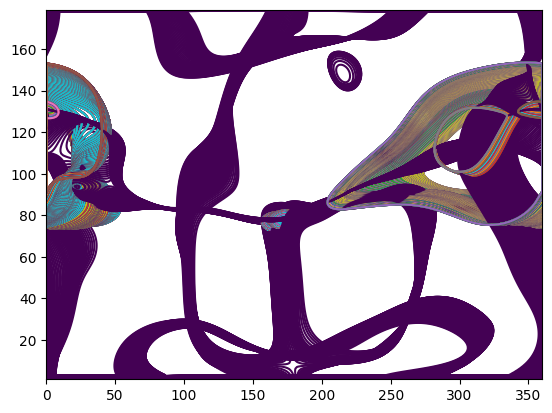

In [10]:
radius = 6371.
theta = np.linspace(1., 179., num=181)  # colatitude in degrees
phi = np.linspace(0., 360., num=361)  # longitude in degrees 改区间需要修改
phim, thetam = np.meshgrid(phi, theta)
radiusm = radius * np.ones(phim.shape)
filepath="D:\Fig\origin data\coeff\covobsx2.txt"

lmax=14
r=6371
n=1
finaly_sub_area = []
finaly_cm_phi = []
finaly_cm_theta = []
years_E = []
year_all = []
F_E_all = []
Ftotal= []
Ftotal_year=[]
finaly_cm_phi_fc=[]
finaly_cm_theta_fc=[]
year_fc_cm=[]
Phi_E_all=[]
Theta_E_all=[]
for year in range(1840,2025,2):
    yr=year
    gsh, hsh = read_gauss_coeffs(filepath, yr, lmax=lmax)
    br,bphi,btheta,lons2d,lats2d=magnetic_field(gsh, hsh, lmax, radius, theta, phi)
    F=np.sqrt(br**2 + bphi**2 + btheta**2)/1000
    
    Fout = calculate_integral(F)
    Fc = 32 * (Fout / Fo2020)
    
    vcenter = Fc  # 想让这个值为白色
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    
    F_real = F
    d_x = dx(thetam, phim, F_real)
    d_y = dy(thetam, phim, F_real)
    dd_x = ddx(thetam, phim, F_real)
    dd_y = ddy(thetam, phim, F_real)
    
    DETH = detH(dd_x, dd_y)
    crossingsX1, crossingsY1= F_C_ObO(phi, theta, d_x, d_y,0)
    E, S = detH_saddle(DETH, thetam, phim, crossingsX1, crossingsY1)
    H_S_lat, H_S_lon=S[:,0],S[:,1]
    H_E_lat, H_E_lon=E[:,0],E[:,1]
    
    F_S=magnetic_point(gsh, hsh, lmax, r, H_S_lat, H_S_lon)
    F_E=magnetic_point(gsh, hsh, lmax, r, H_E_lat, H_E_lon)
    
    #先知道Fc内包含多少点
    mask_S = F_S < Fc
    F_S_selected = np.array(F_S[mask_S])
    lat_S_selected = np.array(H_S_lat[mask_S])
    lon_S_selected = np.array(H_S_lon[mask_S])
    #排序
    # 根据 F_S_selected 从小到大排序
    sort_idx = np.argsort(F_S_selected)
    F_S_selected = F_S_selected[sort_idx]
    lat_S_selected = lat_S_selected[sort_idx]
    lon_S_selected = lon_S_selected[sort_idx]
    
    mask_E = F_E < Fc
    F_E_selected = np.array(F_E[mask_E])
    lat_E_selected = np.array(H_E_lat[mask_E])
    lon_E_selected = np.array(H_E_lon[mask_E])
    print("区域内的E和S点数量分别为：",len(F_E_selected),len(F_S_selected))
    
    #先知道子区域数量
    Num_Fc = num_conter(F,[Fc])
    region_number=Num_Fc + len(F_S_selected)
    print("sub-region 数量为",region_number)
    
    F_b = np.concatenate([F_S_selected, np.array([(Fc/0.999)])])
    
    c_fs = plt.contour(phi, theta, F, levels=[0.999 * F_b[0]])
    paths2 = c_fs.get_paths()  # get contour path(all)
    polygons2 = paths2[0].to_polygons()
    area_s1 = all_area(polygons2)  # sub-region array
    cm_phi_s1, cm_theta_s1 = all_center(polygons2)  # center of mass array
    Asub = []
    for r in range(0, len(area_s1)):
        Asub.append(area_s1[r] / (np.sum(area_s1)))
    Asub = np.array(Asub)
    
    if len(F_b) > 0:
    
        for o in range(1, len(F_b)):
            c_fs = plt.contour(phi, theta, F, levels=[0.999 * F_b[o]])
            paths2 = c_fs.get_paths()  # get contour path(all)# get contour path(all)
            polygons2 = paths2[0].to_polygons()
            area_s2 = all_area(polygons2)  # sub-region array
            cm_phi_s2, cm_theta_s2 = all_center(polygons2)  # 大黄得CM
    
            cm_location = np.column_stack([cm_phi_s1, cm_theta_s1])
            markNo = []
            mark = []
            addNO = []
            marker = 0
            zz = 0
            nn = 0
            mm = 0
            for poly in polygons2:
                lat_line = 90 - poly[:, 1]
                lon_line = poly[:, 0]
                sad_location = np.column_stack([cm_phi_s1, cm_theta_s1])
                if (np.isclose(poly[0,0], 360.0) and np.isclose(poly[-1,0], 360.0)) \
                   or (np.isclose(poly[0,0], 0.0) and np.isclose(poly[-1,0], 0.0)):
                    zz = 1 + zz
                    mm = 1
                    polygon_path = Path(np.vstack([lon_line, poly[:, 1]]).T)
                    inside = polygon_path.contains_points(sad_location)  # S 最大的？
                    if np.any(inside):
                        marker = 1
    
                    polygon_path_s = Path(np.vstack([lon_line, poly[:, 1]]).T)
                    inside_array_s = polygon_path.contains_points(cm_location)  # 布尔数组
                    indices_inside = np.where(inside_array_s)[0]  # 得到在 polygon 内的点的索引（即第几个点）
                    addNO.extend(indices_inside)
    
                else:
                    nn = nn + 1
                    polygon_path = Path(np.vstack([lon_line, poly[:, 1]]).T)
                    inside = polygon_path.contains_points(sad_location)  # S 最大的？
                    mark.append(np.any(inside))
    
                    polygon_path = Path(np.vstack([lon_line, poly[:, 1]]).T)
                    inside_array = polygon_path.contains_points(cm_location)  # 布尔数组
                    # 得到在 polygon 内的点的索引（即第几个点）
                    indices_inside = np.where(inside_array)[0]
                    markNo.append(indices_inside)
    
            if marker == 1:  # 如果有合并区间
                mark.append(True)
                markNo.append(addNO)
            elif marker != 1 and mm == 0:  # 没有区间合并，跳过
                pass  # 或者什么都不做
            elif marker != 1 and mm == 1:  # 没有合并区间，但 mm=1
                mark.append(False)
    
            mark = np.array(mark)
            area_sub = np.zeros_like(Asub, dtype=float)
    
            for i, idxs in enumerate(markNo):
                if len(idxs) > 0:
                    weights = Asub[idxs]
                    print(idxs, weights)
                    area_sub[idxs] = area_s2[i] * weights / np.sum(weights)
            cm_phi_s2 = np.array(cm_phi_s2)
            cm_theta_s2 = np.array(cm_theta_s2)
    
            empty_idx = [i for i in range(len(markNo)) if len(markNo[i]) == 0]
            empty_area = area_s2[empty_idx]
            empty_phi = cm_phi_s2[empty_idx]
            empty_theta = cm_theta_s2[empty_idx]
    
    
            new_cm_phi = []
            new_cm_theta = []
    
            area_sub = np.concatenate([area_sub, empty_area])
            new_cm_phi = np.concatenate([cm_phi_s1, empty_phi])
            new_cm_theta = np.concatenate([cm_theta_s1, empty_theta])
    
            Asub_new = []
            for r in range(0, len(area_sub)):
                Asub_new.append(area_sub[r] / (np.sum(area_sub)))
    
            Asub = np.array(Asub_new)
            cm_phi_s1 = np.array(new_cm_phi)
            cm_theta_s1 = np.array(new_cm_theta)
    
    print("最终划分的面积数", len(Asub))
    
    print(Asub)
    
    c_ft = plt.contour(phi, theta,F, levels=[Fc])
    paths22 = c_ft.get_paths() # get contour path(all)
    polygons22 = paths22[0].to_polygons()
    cm_phi_fc, cm_theta_fc = all_center(polygons22) 
    ar=all_area(polygons22) #sub-region array
    save_area=np.sum(ar)*Asub
    
    #
    Ftotal.append(np.sum(ar))
    Ftotal_year.append(year)
    
    years_E.extend([yr]*len(F_E_selected))
    F_E_all.extend(F_E_selected)
    Phi_E_all.extend(lon_E_selected)
    Theta_E_all.extend(lat_E_selected)
    
    finaly_sub_area.extend(save_area)
    finaly_cm_phi.extend(cm_phi_s1)
    finaly_cm_theta.extend(cm_theta_s1)
    year_all.extend([yr]*len(cm_theta_s1))

    finaly_cm_phi_fc.extend(cm_phi_fc)
    finaly_cm_theta_fc.extend(cm_theta_fc)
    year_fc_cm.extend([yr]*len(cm_theta_fc))

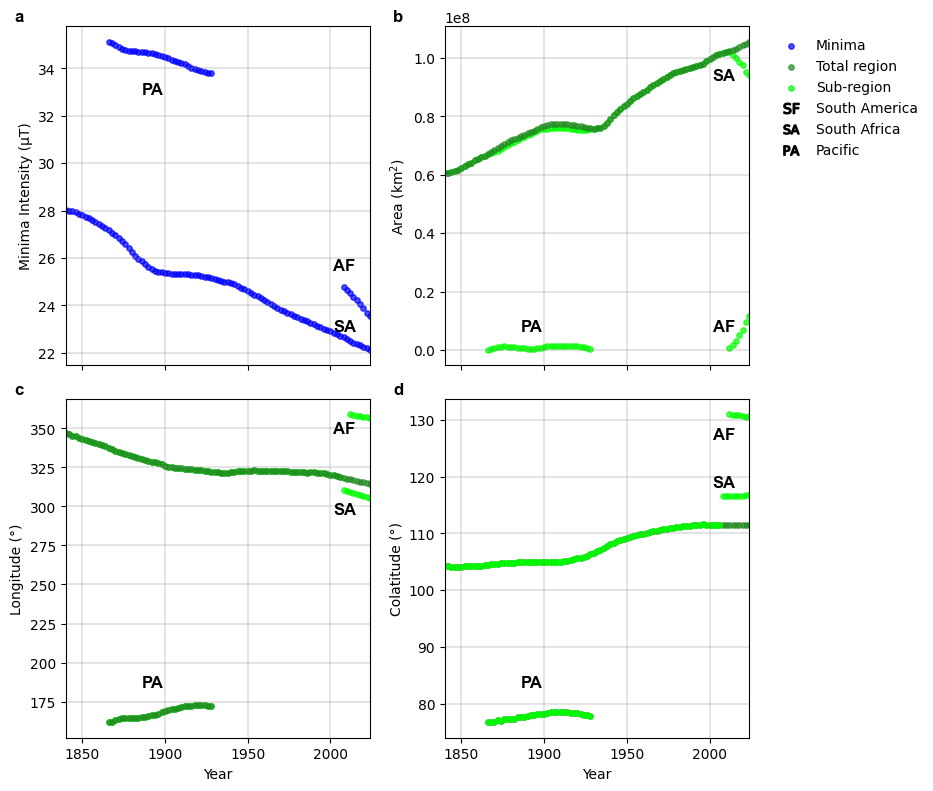

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# ================= Legend text markers (same as previous figure) =================
sa_handle = Line2D([], [], linestyle='None',
                   marker=r'$\mathrm{SA}$',
                   markersize=11,
                   color='black',
                   label='South Africa')

sf_handle = Line2D([], [], linestyle='None',
                   marker=r'$\mathrm{SF}$',
                   markersize=11,
                   color='black',
                   label='South America')

pa_handle = Line2D([], [], linestyle='None',
                   marker=r'$\mathrm{PA}$',
                   markersize=11,
                   color='black',
                   label='Pacific')

# ================= Figure layout =================
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

marker_size = 15
subregionCMcolor = 'lime'

# ---------- Panel (a): Minima intensity ----------
axs[0, 0].scatter(years_E, F_E_all, s=marker_size, color='blue', marker='o', alpha=0.7, label='Minima')

# axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('Minima Intensity (μT)')
axs[0, 0].set_xlim(1840, 2024)

# ---------- Panel (b): Area ----------
axs[0, 1].scatter(year_all, finaly_sub_area, s=marker_size, color=subregionCMcolor, alpha=0.7, marker='o', label=r'Sub-region')
axs[0, 1].scatter(Ftotal_year, Ftotal, s=marker_size, color='forestgreen', alpha=0.7, label=r'$Total region$')

# axs[0, 1].set_xlabel('Year')
axs[0, 1].set_ylabel('Area (km$^2$)')
axs[0, 1].set_xlim(1840, 2024)

# ---------- Panel (c): Longitude ----------
axs[1, 0].scatter(year_all, finaly_cm_phi, s=marker_size, color=subregionCMcolor, marker='o', alpha=0.7)
axs[1, 0].scatter(year_fc_cm, finaly_cm_phi_fc, s=marker_size, color='forestgreen', marker='o', alpha=0.7, label=r'$F_{cm}$ of $A_c$')
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel('Longitude (°)')
axs[1, 0].set_xlim(1840, 2024)

# ---------- Panel (d): Colatitude ----------
axs[1, 1].scatter(year_fc_cm, finaly_cm_theta_fc, s=marker_size, color='forestgreen', marker='o', alpha=0.7, label=r'Total region')
axs[1, 1].scatter(year_all, finaly_cm_theta, s=marker_size, color=subregionCMcolor, marker='o', alpha=0.7, label=r'Sub-region')

axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Colatitude (°)')
axs[1, 1].set_xlim(1840, 2024)

# ---------- Grid (identical style) ----------
for ax in axs.flat:
    ax.grid(True, which='both', color='gray', linestyle='-', linewidth=0.3)


axs[0, 1].tick_params(axis='x', labelbottom=False)
axs[0, 0].tick_params(axis='x', labelbottom=False)
# ---------- AF / SA text labels (same positions & style) ----------
axs[0,0].text(0.88,0.28,'AF',transform=axs[0,0].transAxes, fontsize=12,fontweight='bold',fontfamily='Arial')
axs[0,0].text(0.88,0.10,'SA',transform=axs[0,0].transAxes, fontsize=12,fontweight='bold',fontfamily='Arial')
axs[0,0].text(0.25,0.8,'PA',transform=axs[0,0].transAxes, fontsize=12,fontweight='bold',fontfamily='Arial')


axs[0,1].text(0.88,0.84,'SA',transform=axs[0,1].transAxes, fontsize=12,fontweight='bold',fontfamily='Arial')
axs[0,1].text(0.88,0.10,'AF',transform=axs[0,1].transAxes, fontsize=12,fontweight='bold',fontfamily='Arial')
axs[0,1].text(0.25,0.10,'PA',transform=axs[0,1].transAxes, fontsize=12,fontweight='bold',fontfamily='Arial')

axs[1,0].text(0.88,0.90,'AF',transform=axs[1,0].transAxes, fontsize=12,fontweight='bold',fontfamily='Arial')
axs[1,0].text(0.88,0.66,'SA',transform=axs[1,0].transAxes, fontsize=12,fontweight='bold',fontfamily='Arial')
axs[1,0].text(0.25,0.15,'PA',transform=axs[1,0].transAxes, fontsize=12,fontweight='bold',fontfamily='Arial')

axs[1,1].text(0.88,0.88,'AF',transform=axs[1,1].transAxes,  fontsize=12,fontweight='bold',fontfamily='Arial')
axs[1,1].text(0.88,0.74,'SA',transform=axs[1,1].transAxes,  fontsize=12,fontweight='bold',fontfamily='Arial')
axs[1,1].text(0.25,0.15,'PA',transform=axs[1,1].transAxes,  fontsize=12,fontweight='bold',fontfamily='Arial')
# ---------- Panel labels ----------
labels = ['a', 'b', 'c', 'd']
for ax, lab in zip(axs.flat, labels):
    ax.text(-0.17, 1.05, lab, transform=ax.transAxes, fontsize=12, fontweight='bold', fontfamily='Arial', va='top', ha='left')

# ---------- Legend (merged, identical logic) ----------
handles1, labels1 = axs[0, 0].get_legend_handles_labels()
handles4, labels4 = axs[1, 1].get_legend_handles_labels()

handles = handles1 + handles4 + [sf_handle, sa_handle, pa_handle]
labels  = labels1  + labels4  + ['South America', 'South Africa',"Pacific"]

axs[0, 1].legend(  handles, labels,  loc='upper left',  bbox_to_anchor=(1.05, 1.0), frameon=False)

# ---------- Layout ----------
plt.tight_layout(rect=[0, 0, 0.95, 1])
# plt.savefig("D:/Fig/7_Area_CHAOS.png", dpi=300,bbox_inches='tight')
plt.show()
